# Bank Customer Churn Prediction - Python Analysis Notebook
## Capstone Project | Fintech / Banking Domain | Data Science & Business Impact

This notebook serves as the core analytical engine for the Customer Churn Prediction project, focused on identifying high-risk churn customers within a retail banking context. All phases of the Python-based workflow — from data ingestion to machine learning modeling — will be executed here.

###  Objectives:
- Load and explore the Bank Churn dataset
- Clean and preprocess features for modeling
- Perform exploratory data analysis (EDA)
- Train classification models (Logistic Regression, Random Forest, XGBoost)
- Evaluate model performance using ROC-AUC, precision, recall, and confusion matrix
- Explain model results using feature importance and SHAP
- (Optional) Simulate A/B testing for retention campaign analysis

###  Dataset:
- Source: [Bank Customer Churn Dataset on Kaggle](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)
- Size: ~10,000 rows × 12 columns
- Target Variable: `churn` (1 = churned)

> This notebook is designed to provide end-to-end insights and will be the central location for all data preprocessing, modeling, and interpretation tasks throughout the Capstone project.


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Load dataset
# Replace the path below with your actual file location
df = pd.read_csv('Jupyter Notebook/bank-customer-churn-prediction/bank-customer-churn-prediction/data/Bank_Customer_Churn_Prediction.csv')
df.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df['churn'].value_counts(normalize=True)

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [6]:
df['country'].value_counts(normalize=True)

country
France     0.5014
Germany    0.2509
Spain      0.2477
Name: proportion, dtype: float64

In [7]:
df['gender'].value_counts(normalize=True)

gender
Male      0.5457
Female    0.4543
Name: proportion, dtype: float64

In [8]:
# drop the useless column
df.drop('customer_id', axis=1, inplace=True)

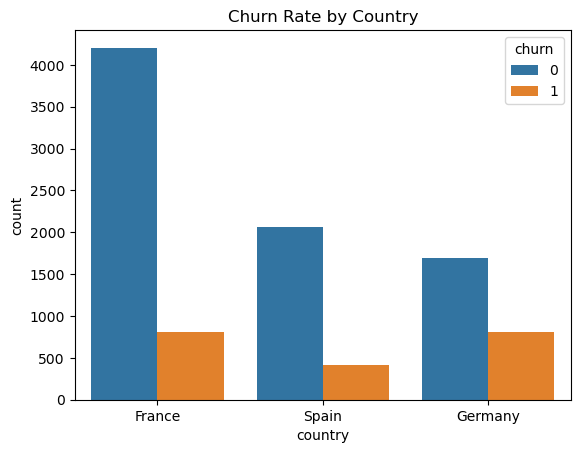

In [9]:
# Churn by Geography
sns.countplot(x='country', hue='churn', data=df)
plt.title('Churn Rate by Country')
plt.show()

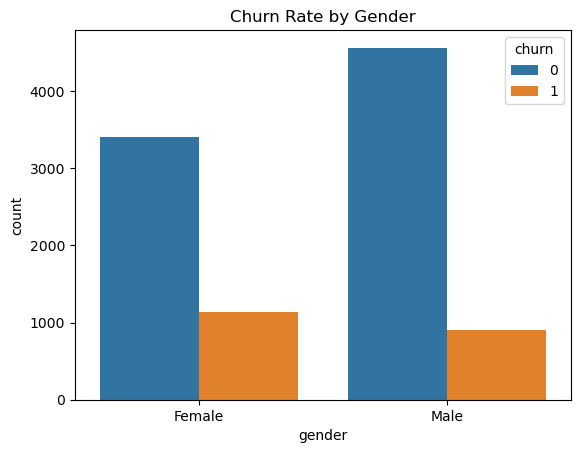

In [10]:
# Churn by Gender
sns.countplot(x='gender', hue='churn', data=df)
plt.title('Churn Rate by Gender')
plt.show()

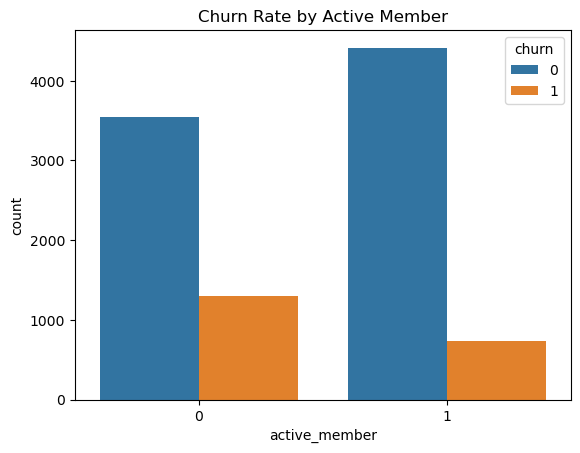

In [11]:
# Churn by Active
sns.countplot(x='active_member', hue='churn', data=df)
plt.title('Churn Rate by Active Member')
plt.show()

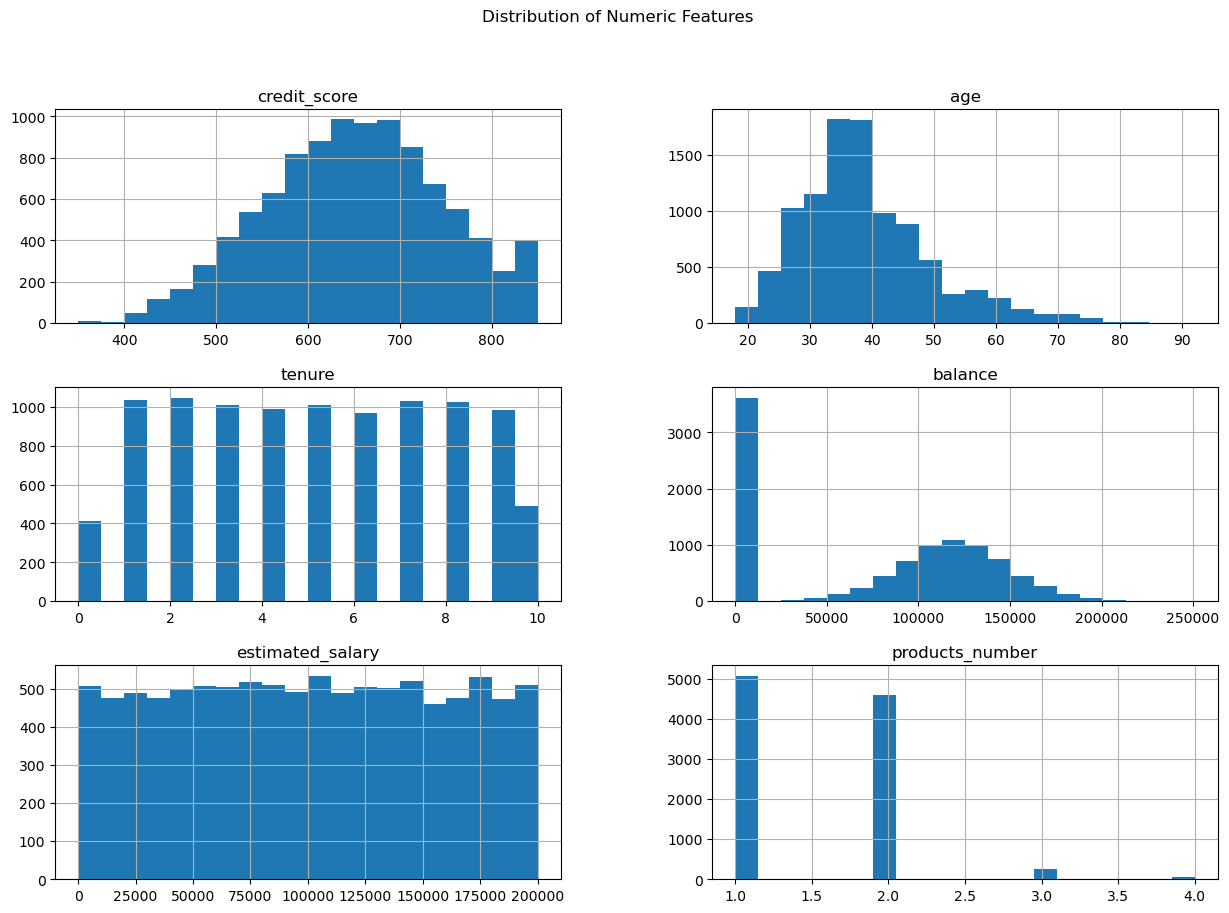

In [12]:
# Numeric Feature Distributions
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'products_number']
df[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numeric Features")
plt.show()

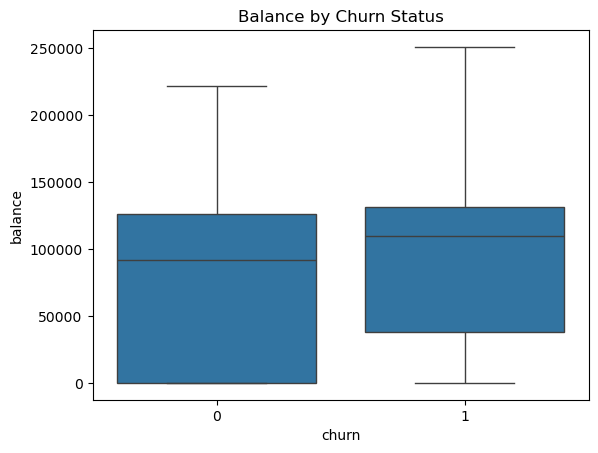

In [13]:
# Churn Rate vs balance
sns.boxplot(x='churn', y='balance', data=df)
plt.title("Balance by Churn Status")
plt.show()

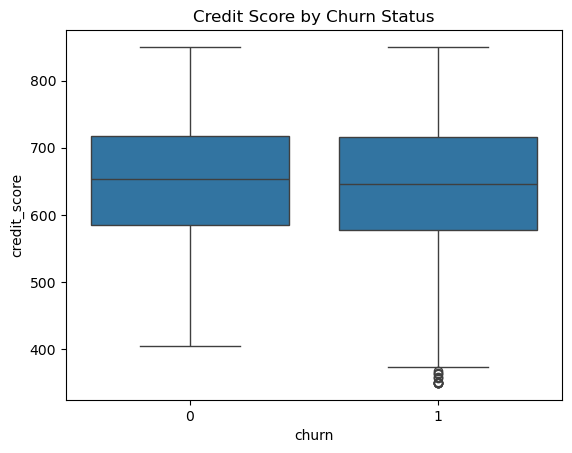

In [14]:
# Churn Rate vs credit score
sns.boxplot(x='churn', y='credit_score', data=df)
plt.title("Credit Score by Churn Status")
plt.show()

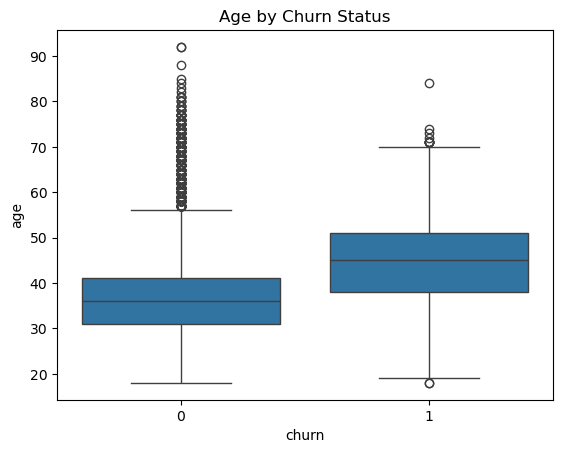

In [15]:
# Churn Rate vs age
sns.boxplot(x='churn', y='age', data=df)
plt.title("Age by Churn Status")
plt.show()

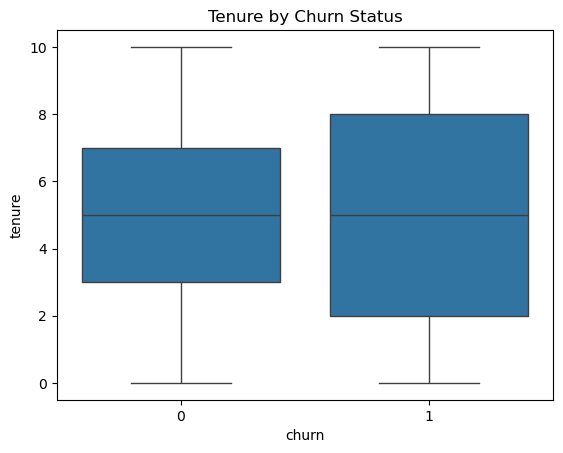

In [16]:
# Churn Rate vs tenure
sns.boxplot(x='churn', y='tenure', data=df)
plt.title("Tenure by Churn Status")
plt.show()

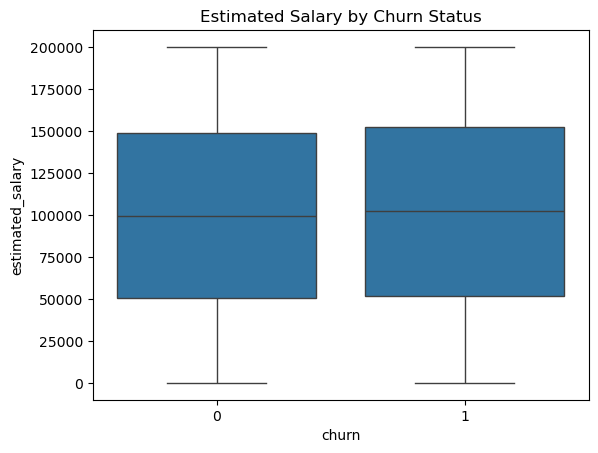

In [17]:
# Churn Rate vs estimated salary
sns.boxplot(x='churn', y='estimated_salary', data=df)
plt.title("Estimated Salary by Churn Status")
plt.show()

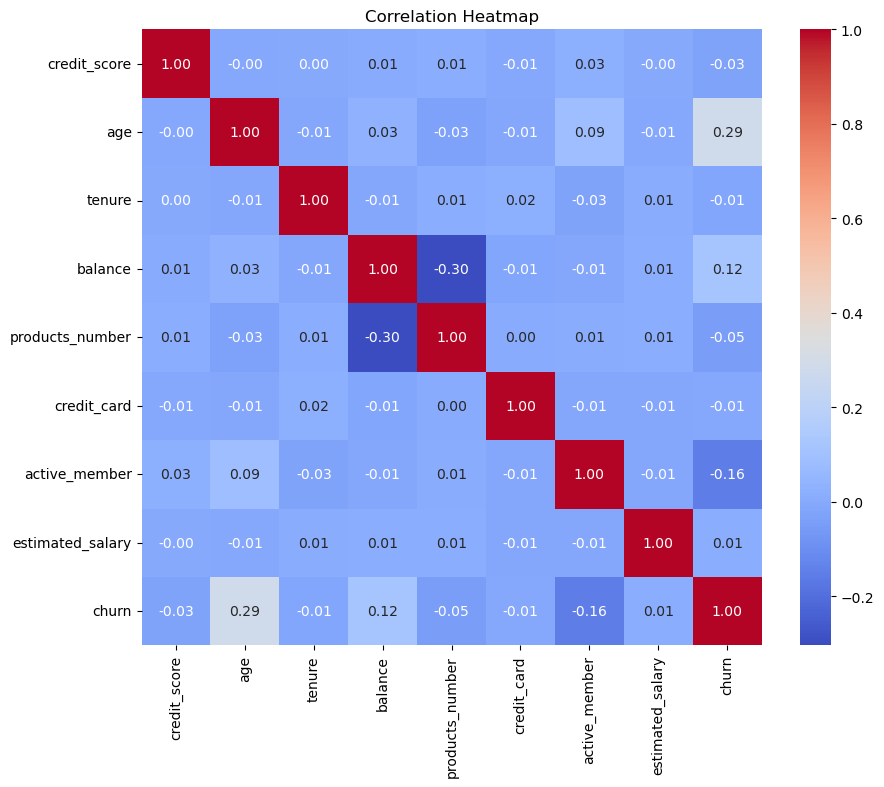

In [18]:
# Heatmap
df_filtered = df.loc[:, ~df.columns.isin(['country', 'gender'])]

corr = df_filtered.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [19]:
df.groupby('products_number')['churn'].mean().sort_values(ascending=False)

products_number
4    1.000000
3    0.827068
1    0.277144
2    0.075817
Name: churn, dtype: float64

In [20]:
'''products = 4 seems to be an outlier, 
And consider why 3 products have 83% churn rate 
'''
df['products_number'].value_counts(normalize=True)

products_number
1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: proportion, dtype: float64

In [21]:
df['products_grouped'] = df['products_number'].apply(lambda x: '3+' if x >= 3 else str(x))
df['products_grouped'].value_counts(normalize=True)

products_grouped
1     0.5084
2     0.4590
3+    0.0326
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Churn Rate by Product Group (Binned)')

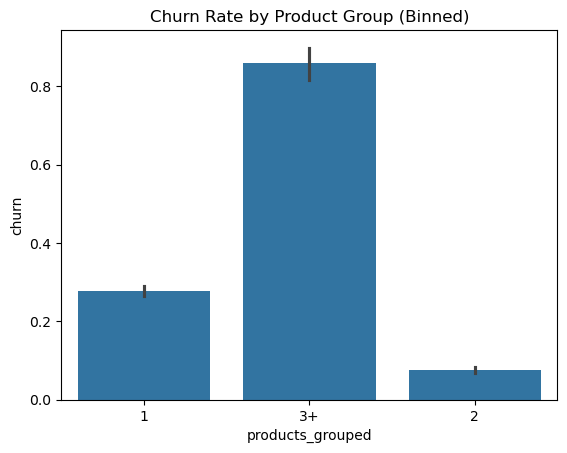

In [22]:
sns.barplot(x='products_grouped', y='churn', data=df)
plt.title("Churn Rate by Product Group (Binned)")

# Modeling Preprocessing
##  Top Variables Likely to Predict Churn
**Based on Exploratory Data Analysis:**

### Good Predictors:
- `age`: Older customers show higher churn probability.
- `active_member`: Inactive customers are more likely to churn.
- `products_number`: Customers with 3+ products have extremely high churn.
- `country_Germany`: German customers churn more than others (to be encoded).
- `balance`: May have a nonlinear relationship with churn.

### Weak Predictors:
- `estimated_salary`: Uniform distribution, little difference across churn.
- `credit_score`: Relatively flat relationship to churn.
- `tenure`: No strong visual correlation with churn.

> These insights will guide feature selection and help refine model input.



In [23]:
"""
What's the issue?
    Most machine learning models (like Logistic Regression, Random Forest, XGBoost) 
    can't process text data like "France" or "Male" — they require numerical inputs.
"""
# Outlier Handling
df['products_grouped'] = df['products_number'].apply(lambda x: '3+' if x >= 3 else str(x))
df['age_flag'] = df['age'].apply(lambda x: 1 if x > 70 else 0)
df['high_balance'] = df['balance'].apply(lambda x: 1 if x > 200000 else 0)

# One-Hot Encode
df_encoded = pd.get_dummies(df, columns=['country', 'gender', 'products_grouped'], drop_first=True)
df_encoded.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_flag,high_balance,country_Germany,country_Spain,gender_Male,products_grouped_2,products_grouped_3+
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,False,False,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,False,True,False,False,False
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,False,False,False,False,True
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,False,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,False,True,False,False,False


**Explanation:
StandardScaler transforms values to have mean = 0 and std = 1
Helps Logistic Regression and SVM work properly
Not needed for tree models, but won’t hurt**

In [24]:
scale_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
scaler = StandardScaler()
df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])

X = df_encoded.drop('churn', axis=1)
y = df_encoded['churn']

In [25]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)